<a href="https://colab.research.google.com/github/AdamHuang0402/MLclass0423/blob/master/vgg16_mongo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 遷移學習
# Batch Normalization : 先用高斯分布調到0~1，然後再線性調整。  最佳平均和最佳標準差
# 遷移變化太大的時候，先BN，再來再減少參數

import zipfile
f = zipfile.ZipFile("/content/drive/My Drive/MongoAI/C1-P1_Train-20200624T093105Z-001.zip")
f.extractall("./datasets")

In [ ]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
import pandas as pd 
fname = pd.read_csv("drive/My Drive/MongoAI/train.csv")
fname

,image_id,label
0,00002.jpg,C
1,00003.jpg,C
2,00004.jpg,B
3,00005.jpg,A
4,00007.jpg,A
...,...,...
5595,07993.jpg,C
5596,07996.jpg,A
5597,07998.jpg,A
5598,07999.jpg,A


In [ ]:
s='datasets/C1-P1_Train/02649.jpg'
s.split("/")[2]

'02649.jpg'

In [ ]:
import glob
import pandas as pd
# 先不讀取圖片, 真的要訓練才讀
df = pd.DataFrame(columns=["path","target"])
for p in glob.glob("datasets/C1-P1_Train/*.jpg"):
    
    label=''
    for i, t in enumerate(fname["image_id"]):
      if p.split("/")[2] == t:
        label = fname["label"][i]
        break
    if label =='A':
      label='0'
    elif label =='B':
      label='1'
    else: 
      label='2'

    s = pd.Series([p,label], index=["path","target"])
    df = df.append(s, ignore_index=True)
df

,path,target
0,datasets/C1-P1_Train/01919.jpg,2
1,datasets/C1-P1_Train/02435.jpg,1
2,datasets/C1-P1_Train/01364.jpg,2
3,datasets/C1-P1_Train/01854.jpg,0
4,datasets/C1-P1_Train/01974.jpg,2
...,...,...
5595,datasets/C1-P1_Train/02869.jpg,1
5596,datasets/C1-P1_Train/02455.jpg,1
5597,datasets/C1-P1_Train/06402.jpg,1
5598,datasets/C1-P1_Train/07548.jpg,2


In [ ]:
# # 答案: 處理成數字
# # replace()
# u = df["target"].unique()
# trans ={name:i for i,name in enumerate(u)}
# reverse_trans = {i:name for name,i in trans.items()}
# print(trans)
# print(reverse_trans)
# df["target"] = df["target"].replace(trans)
# # y_test = test_df["作者"].replace(trans)
# df

datasets/C1-P1_Train/02518.jpg
(1088, 816) 0


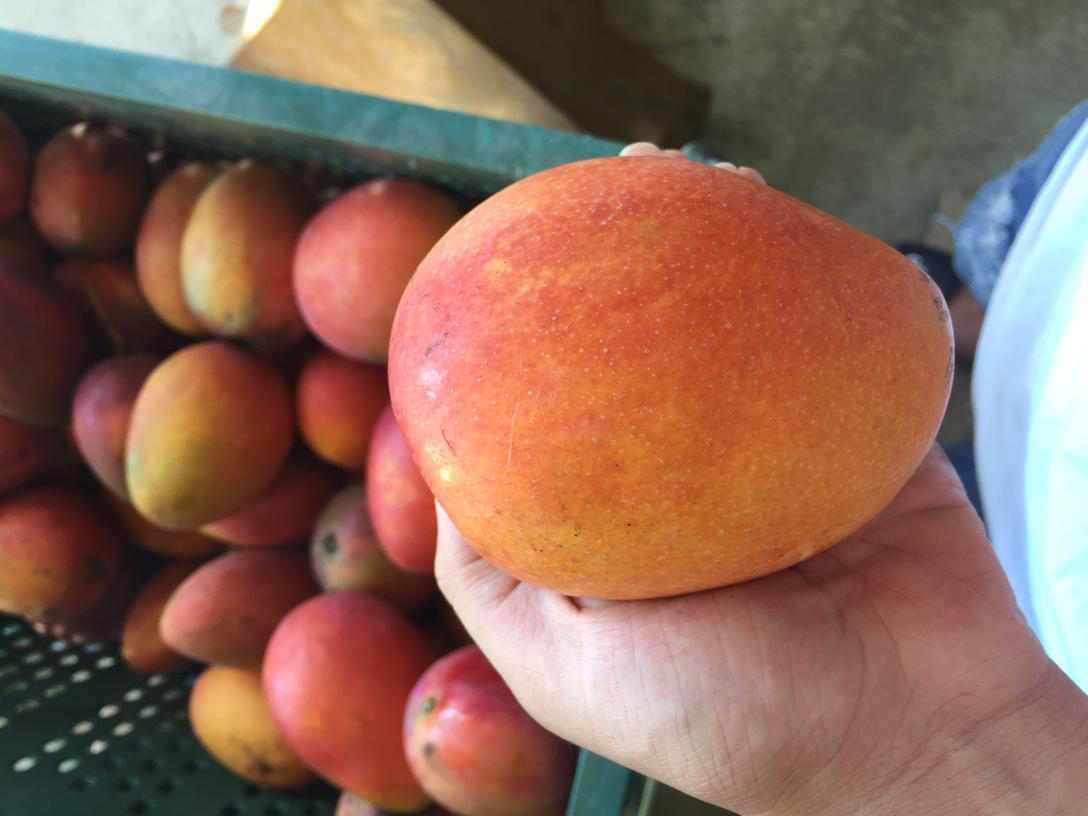

In [ ]:
from keras.preprocessing.image import load_img
import random
c = random.randint(0, 5599)
print(df["path"][c])
img = load_img(df["path"][c])
print(img.size , df["target"][c] )
img

(224, 224)


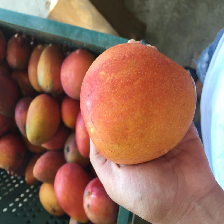

In [ ]:
# target_size 可以resize看圖片
img = load_img(df["path"][c], target_size=(224, 224))
print(img.size)
img

In [ ]:
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization
# CNN(眼睛)  # 使用別人的參數，固定住，不動它  Non-trainable params: 14,715,712
for l in vgg.layers:
    l.trainable = False
# BN(血管) 防止訓練資料沒有常態分佈，而導致訓練沒效果，BN可使訓練資料常態分佈
x = BatchNormalization()(vgg.output)
# MLP(大腦)
x = Flatten()(x)
# vgg 最後參數是7*7*512 = 25088，/10 ，所以約使用2048
x = Dense(units=2048, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
# 貓和狗分類: units = 1, units = 2 都可以
#         : sigmoid  , softmax
x = Dense(units=3, activation="softmax")(x)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
cnn.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [ ]:
from sklearn.model_selection import train_test_split
# 真的要開始切分和訓練的時候, 請你把你的pandas轉成numpy的array
# 先處理一下答案, 把它轉化成為one-hot
from keras.utils.np_utils import to_categorical
y_cat = to_categorical(df["target"])
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(y_cat),
                                                    test_size=0.1)
# show一個y_train給你看
y_train[-1]

array([0., 1., 0.], dtype=float32)

In [ ]:
# 你偷誰的模型, 就要使用他的預處理方式
from keras.applications.vgg16 import preprocess_input
batch_size = 100
for i in range(5):
    # randint(下限(包括), 上限(不包括), 幾個)   np不包括
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    # numpy好用之處: array[ 索引list ]
    imglist = []
    for fn in x_train[idx]:   # 拿到路徑
        # 讀取圖片並且使用我們偷來的模型的預處理方式來處理一下 : preprocess_input(np.array(img))
        img = load_img(fn, target_size=(224, 224))
        img = preprocess_input(np.array(img))
        imglist.append(img)
    x = np.array(imglist)
    y = y_train[idx]
    result = cnn.train_on_batch(x, y)
    print("-----Times", i, "-----")
    print(result)

-----Times 0 -----
[1.3570209, 0.31]
-----Times 1 -----
[23.708242, 0.48]
-----Times 2 -----
[18.551922, 0.31]
-----Times 3 -----
[1.815823, 0.52]
-----Times 4 -----
[2.722467, 0.54]


In [ ]:
batch_size = 100

# randint(下限(包括), 上限(不包括), 幾個)
idx = np.random.randint(0, x_test.shape[0], batch_size)
# numpy好用之處: array[ 索引list ]
imglist = []
oriimglist = []
for fn in x_test[idx]:
    # 讀取圖片並且使用我們偷來的模型的預處理方式來處理一下
    img = load_img(fn, target_size=(224, 224))
    # 先把原圖留下來
    oriimglist.append(np.array(img))
    img = preprocess_input(np.array(img))
    imglist.append(img)
x = np.array(imglist)
y = y_test[idx]
cnn.evaluate(x, y)


100/100 [==============================] - 5s 48ms/step


[5.330917882919311, 0.699999988079071]

In [ ]:
# 作圖(參考)
pre = cnn.predict(x).argmax(axis=-1)
# 拿出預測標籤最大值的索引
pre

array([0, 1, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 1, 0, 0, 2, 1, 2, 2, 0, 1, 2,
       0, 0, 0, 2, 0, 1, 1, 2, 2, 2, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 2,
       0, 1, 1, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 1, 1, 2,
       0, 1, 1, 1, 0, 1, 1, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 2, 2, 1,
       1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 2, 1])

In [ ]:
# 拿出正確答案最大值的索引
y.argmax(axis=-1)

array([1, 1, 1, 2, 0, 2, 2, 1, 0, 2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 0, 0,
       1, 0, 1, 2, 0, 1, 2, 2, 2, 2, 0, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 2, 1, 2, 0, 0, 0, 2, 2, 2, 0, 1, 1, 1, 2, 0, 0, 2, 1, 2,
       0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 2, 1,
       0, 0, 2, 2, 1, 1, 2, 2, 0, 1, 2, 0])

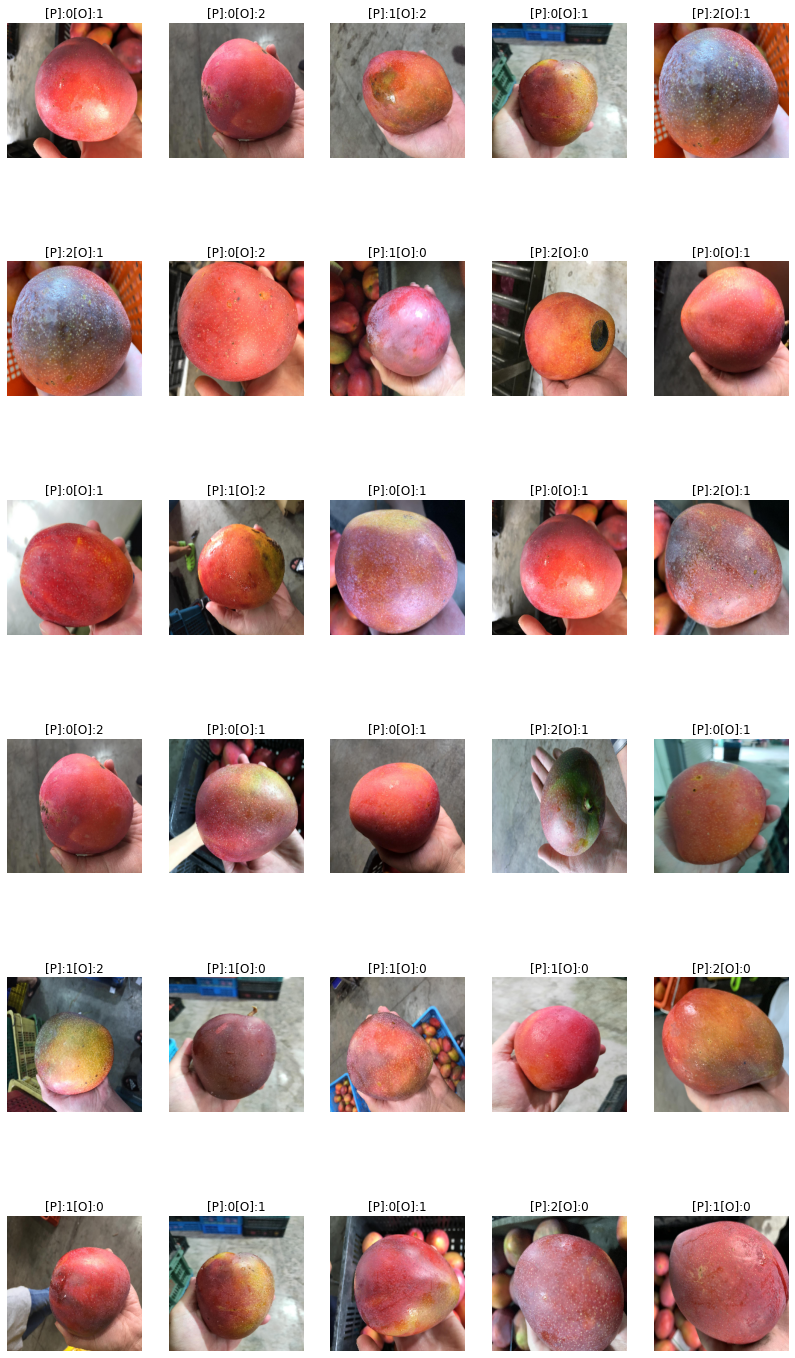

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
idx = np.nonzero(pre != y.argmax(axis=-1))[0]
width = 5
height = int(len(idx) / 5) + 1
plt.figure(figsize=(14, 30))
for (i, img) in enumerate(np.array(oriimglist)[idx]):
    plt.subplot(height, width, i + 1)
    t = "[P]:" + str(pre[idx][i]) + "[O]:" + str(y.argmax(axis=-1)[idx][i])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)